# 🔍 DWSIM Air Cooling Example

**Created by: Prof. Nicolas Spogis, Ph.D.**  
Phone/WhatsApp: +55 (19) 99844-0460  
Email: nicolas.spogis@gmail.com | nicolas.spogis@ai4tech.ai  
LinkTree: [https://linktr.ee/Ai4Tech](https://linktr.ee/Ai4Tech)

In [1]:
# remove the following two lines to run on linux
import pythoncom
pythoncom.CoInitialize()

from opyrability import multimodel_rep, OI_eval
import numpy as np
import matplotlib.pyplot as plt

In [2]:
########################################################################################################################
# Call DWSIM DLLs
########################################################################################################################
import clr

# Change your DWSIM installation path

In [3]:
dwsimpath = "C:\\Users\\nicol\\AppData\\Local\\DWSIM\\" 

In [4]:
clr.AddReference(dwsimpath + "\\CapeOpen.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Automation.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Interfaces.dll")
clr.AddReference(dwsimpath + "\\DWSIM.GlobalSettings.dll")
clr.AddReference(dwsimpath + "\\DWSIM.SharedClasses.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Thermodynamics.dll")
clr.AddReference(dwsimpath + "\\DWSIM.UnitOperations.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Inspector.dll")
clr.AddReference(dwsimpath + "\\System.Buffers.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Thermodynamics.ThermoC.dll")

In [5]:
########################################################################################################################
# Open DWSIM Automation
########################################################################################################################
def open_DWSIM(dwsimpath, FlowsheetFile):
    from DWSIM.Automation import Automation3
    manager = Automation3()
    myflowsheet = manager.LoadFlowsheet(FlowsheetFile)
    return manager, myflowsheet

In [6]:
########################################################################################################################
# Open DWSIM Automation
########################################################################################################################
FlowsheetFile = "Air Cooling.dwxmz"
manager, myflowsheet = open_DWSIM(dwsimpath, FlowsheetFile)

In [7]:
########################################################################################################################
# Call DWSIM -> Change Input Parameters -> Solve - Get Output Parameters
########################################################################################################################
def opyrability_model(AIS):
    global manager, myflowsheet
    # Set Input Parameters
    obj = myflowsheet.GetFlowsheetSimulationObject('Compressor Inlet')
    feed = obj.GetAsObject()
    feed.SetTemperature(AIS[0] + 273.15)  #K

    obj = myflowsheet.GetFlowsheetSimulationObject('Condenser Temperature Specification')
    feed = obj.GetAsObject()
    feed.SetTemperature(AIS[1] + 273.15)  #K

    # Request a calculation
    errors = manager.CalculateFlowsheet4(myflowsheet)

    mySpreadsheet = myflowsheet.GetSpreadsheetObject()
    mySpreadsheet.Worksheets[0].Recalculate()

    # Get Output Parameters
    obj = myflowsheet.GetFlowsheetSimulationObject('COP')
    feed = obj.GetAsObject()
    COP = feed.GetEnergyFlow()*3412.142         #Convert Result

    obj = myflowsheet.GetFlowsheetSimulationObject('CAPEX')
    feed = obj.GetAsObject()
    CAPEX = feed.GetEnergyFlow()*3412.142        #Convert Result

    results = np.array([COP, CAPEX])
    return results

In [8]:
########################################################################################################################
# Run One Case to Test
########################################################################################################################
results = opyrability_model([18.0,55.5])
print(f"COP = {results[0]}")
print(f"CAPEX = {results[1]}")

COP = 3.7839990296762616
CAPEX = 1377.7669675704324


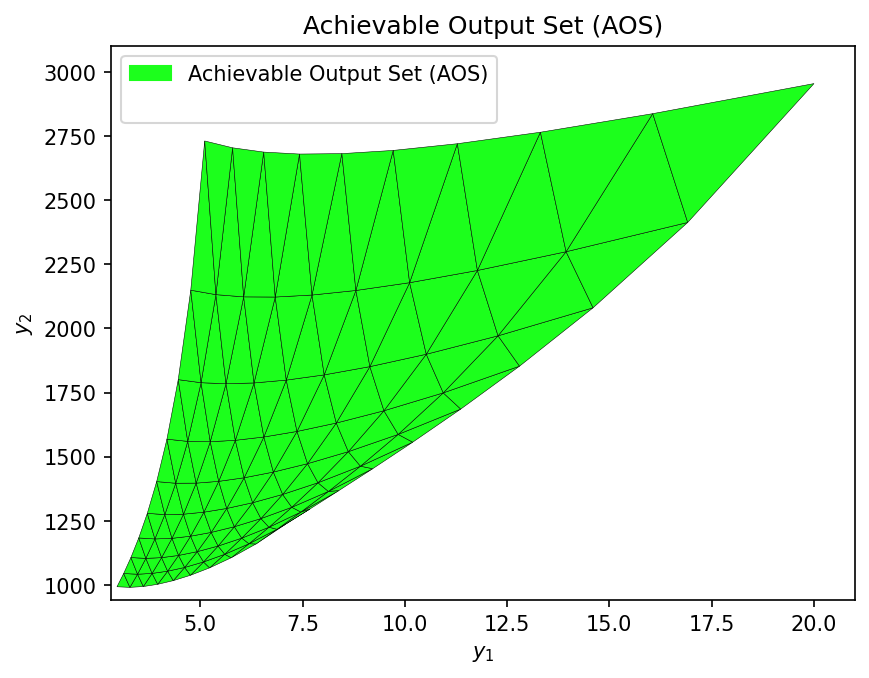

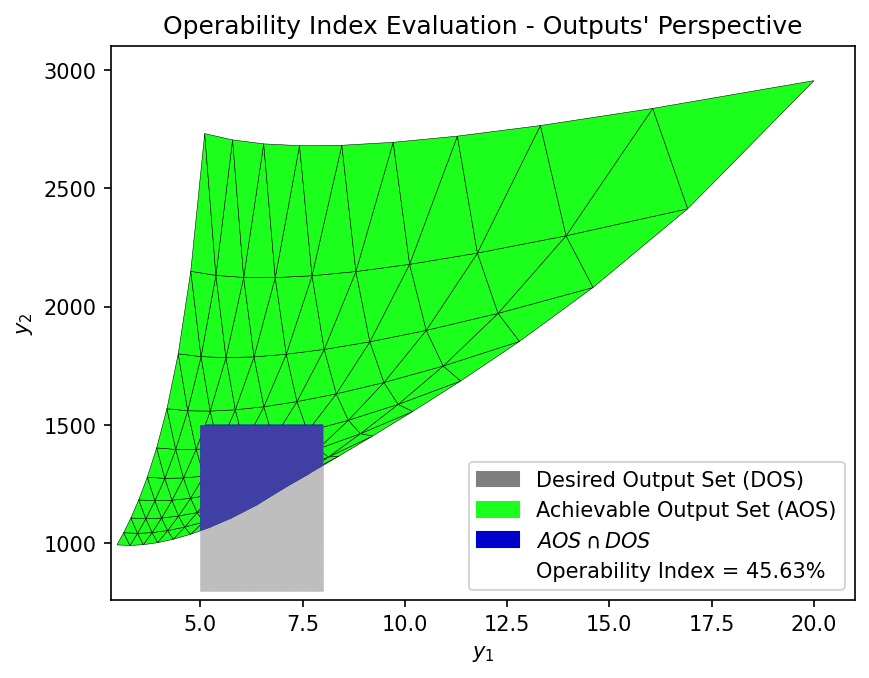

In [9]:
########################################################################################################################
# Defining the AIS and DOS Bounds
########################################################################################################################
DOS_bounds =  np.array([[5, 8],
                        [800, 1500]])

AIS_bounds =  np.array([[10, 25],
                        [35, 55]])

AIS_resolution =  [10, 10]

AOS_region = multimodel_rep(opyrability_model, AIS_bounds, AIS_resolution, plot=True)
OI = OI_eval(AOS_region, DOS_bounds, plot=True)